In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

from simulator import Simulation
from tqdm.auto import tqdm
import itertools
import matplotlib as mpl

warnings.simplefilter(action='ignore', category=UserWarning)

In [3]:
def plot_distribution(project_df):    
    fig, ax = plt.subplots(figsize=(8,5))
    project_df['token_amount'].plot(kind='bar', width=1, ax=ax)
    ax.set_xticks([])
    ax.set_xlabel("")
    ax.set_ylabel("Tokens")
    # fig.show()
    
    
def plot_alignment(project_df):    
    fig, ax = plt.subplots(figsize=(8,5))
    project_df.plot(kind='scatter', x='rating', y='token_amount', ax=ax)
    ax.set_ylabel("Tokens")
    ax.set_xlabel("Impact")
    ax.set_xticks([])    
    # fig.show()

def plot_all(project_df, save_fp=None):
    fig, ax = plt.subplots(1, 2, figsize=(10,4), sharey=True)
    project_df['token_amount'].plot(kind='bar', width=1, ax=ax[0])
    project_df.plot(kind='scatter', x='rating', y='token_amount', ax=ax[1])
    ax[0].set_xticks([])
    ax[0].set_xlabel("")
    ax[0].set_ylabel("Pct Tokens Allocated")
    ax[1].set_ylabel("")
    ax[1].set_xlabel("Impact")
    ax[1].set_xticks([])
    plt.tight_layout()
    if save_fp:
        plt.savefig(save_fp)
    
    
def analyze_simulation(results, generate_plots=False):
    summary = pd.Series(results).iloc[:-1].apply(lambda x: int(x) if isinstance(x, float) else x)
    data = results['data']
    project_df = pd.DataFrame(data).sort_values(by='token_amount', ascending=False)
    if generate_plots:
        plot_all(project_df)
    return summary

# Base Model

In [4]:
# simulation = Simulation()

# simulation.initialize_round(
#     max_funding=200000,
# )
# simulation.randomize_voters(
#     num_voters=50, 
#     willingness_to_spend=1.0, 
#     laziness_factor=0.2, 
#     expertise_factor=0.7
# )
# simulation.randomize_projects(
#     num_projects=137
# )

# results = simulation.simulate_voting_and_scoring(
#     n=100,
#     scoring_method='median',
#     quorum=5,
#     min_amount=2000,
#     normalize=True
# )

In [5]:
# analyze_simulation(results)

### Normalize to the voting that we will be doing (100 votes)

In [6]:
## Num Projects > Quorum when sweeping Quorum
quorum_vec = list(np.arange(1, 25+1))
score_fn = ['mean']  # note quorum doesnt depend on score fn
sim_configs = list(itertools.product(quorum_vec, score_fn))

project_pass_vec = []
for sim_config in tqdm(sim_configs):
    q, score_fn = sim_config
    simulation = Simulation()

    simulation.initialize_round(
        max_funding=100,
    )
    simulation.randomize_voters(
        num_voters=50, 
        willingness_to_spend=1.0, 
        laziness_factor=0.1, 
        expertise_factor=0.9
    )
    simulation.randomize_projects(
        num_projects=137
    )

    results = simulation.simulate_voting_and_scoring(
        n=100,
        scoring_method=score_fn,
        quorum=q,
        min_amount=1,
        normalize=True
    )
    summary = analyze_simulation(results, generate_plots=False)
    project_pass_vec.append(summary.num_projects_above_quorum)


  0%|          | 0/25 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Effect of Quorum on the Number of Funded Projects \n Total Projects = 137')

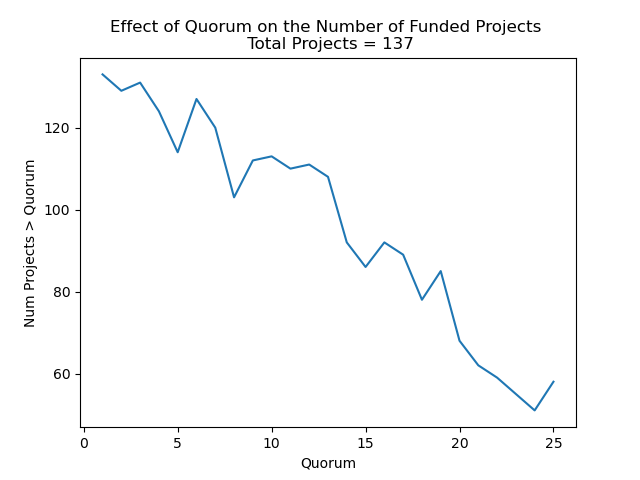

In [7]:
plt.figure()
plt.plot(quorum_vec, project_pass_vec)
plt.xlabel('Quorum')
plt.ylabel('Num Projects > Quorum')
plt.title('Effect of Quorum on the Number of Funded Projects \n Total Projects = 137')

In [8]:
## Num Projects > Quorum when sweeping Quorum
score_fn = ['mean', 'median', 'quadratic']
quorum_vec = list(np.arange(1, 10+1))

sim_configs = list(itertools.product(quorum_vec, score_fn))

pass_results = []
for sim_config in tqdm(sim_configs):
    q, score_fn = sim_config
    simulation = Simulation()

    simulation.initialize_round(
        max_funding=100,
    )
    simulation.randomize_voters(
        num_voters=50, 
        willingness_to_spend=1.0, 
        laziness_factor=0.1, 
        expertise_factor=0.9
    )
    simulation.randomize_projects(
        num_projects=137
    )

    results = simulation.simulate_voting_and_scoring(
        n=100,
        scoring_method=score_fn,
        quorum=q,
        min_amount=1,
        normalize=True
    )
    summary = analyze_simulation(results, generate_plots=False)
    data = results['data']
    project_df = pd.DataFrame(data).sort_values(by='token_amount', ascending=False)
    pass_results.append({
        'quorum': q,
        'score_fn': score_fn,
        'project_df': project_df,
    })

  0%|          | 0/30 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Effect of `score_fn` on Funding Distribution')

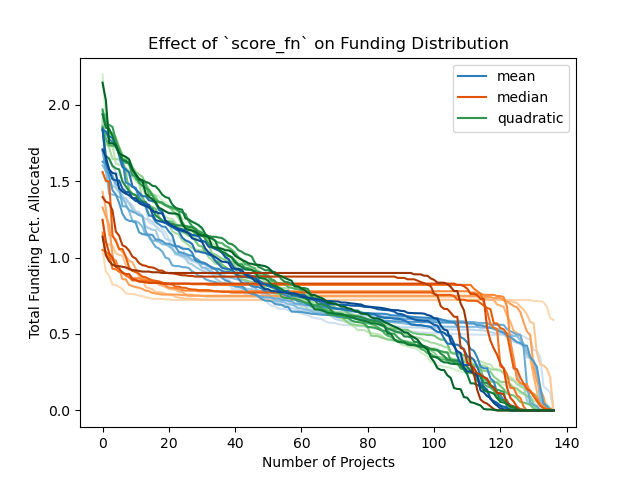

In [9]:
plt.figure()
cmap_means = mpl.colormaps['Blues']
cmap_medians = mpl.colormaps['Oranges']
cmap_quadratics = mpl.colormaps['Greens']
cmap_access_vec = np.linspace(0.2, 0.9, len(quorum_vec))

for p in pass_results:
    q = p['quorum']
    cmap_ix = cmap_access_vec[quorum_vec.index(q)]
    if p['score_fn'] == 'mean':
        cc = cmap_means(cmap_ix)
        plt.plot(p['project_df']['token_amount'].values, color=cc)
    elif p['score_fn'] == 'median':
        cc = cmap_medians(cmap_ix)
        plt.plot(p['project_df']['token_amount'].values, color=cc)
    elif p['score_fn'] == 'quadratic':
        cc = cmap_quadratics(cmap_ix)
        plt.plot(p['project_df']['token_amount'].values, color=cc)

plt.plot(0,0, color=cmap_means(0.7), label='mean')
plt.plot(0,0, color=cmap_medians(0.7), label='median')
plt.plot(0,0, color=cmap_quadratics(0.7), label='quadratic')
plt.legend()

plt.xlabel('Number of Projects')
plt.ylabel('Total Funding Pct. Allocated')
plt.title('Effect of `score_fn` on Funding Distribution')
# plt.plot(pass_results[0]['project_df']['token_amount'].values)  # this is sorted!
# plt.plot(pass_results[1]['project_df']['token_amount'].values)